# Neural Networks Fundamentals
This session will guide you through building, training, and evaluating a neural network using the MNIST dataset in PyTorch. We'll explore key concepts such as data preprocessing, feedforward passes, activation functions, loss functions, backpropagation, and model evaluation. Finally, we'll save and load the trained model to make predictions.

## 1. MNIST Dataset

The MNIST dataset contains images of handwritten digits (0-9) and their corresponding labels. It includes:
- **Training Set**: 60,000 images
- **Test Set**: 10,000 images  
Each image is grayscale, with a resolution of **28x28 pixels**.

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam


from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Normalization
Normalization scales pixel values to a smaller range (e.g., [0, 1] or [-1, 1]), helping the model converge faster and avoid large gradient updates.

In [5]:
# Define transformations: normalize pixel values
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize pixel values to [-1, 1]
    ]
)

`transforms.Compose()` is used to define a pipeline of transformations applied to each image in the dataset.

`transforms.ToTensor()`
- Converts an image (PIL Image or NumPy array) to a PyTorch tensor.
- The pixel values of the image are scaled to the range $([0, 1])$ by dividing each pixel value by 255. For example, a pixel value of $(255)$ becomes $(1.0)$, and $(0)$ remains $(0.0)$.

`transforms.Normalize((0.5,), (0.5,))`
- Normalizes the tensor values to have a mean of $(0)$ and a standard deviation of $(1)$.
- Formula for normalization:
  $$
  \text{Normalized Value} = \frac{\text{Value} - \text{Mean}}{\text{Standard Deviation}}
  $$
  Here, the mean is $(0.5)$ and the standard deviation is $(0.5)$, so:
  $$
  \text{Normalized Value} = \frac{\text{Value} - 0.5}{0.5} = 2 \cdot (\text{Value} - 0.5)
  $$
  This scales pixel values from $([0, 1])$ (after `ToTensor`) to $([-1, 1])$:
  - $(0)$ becomes $(-1)$
  - $(0.5)$ becomes $(0)$
  - $(1)$ becomes $(1)$

By normalizing the pixel values, the model can learn faster and better because all inputs have a similar scale.

In [6]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



The `datasets.MNIST` class downloads and loads the MNIST dataset with the transformations applied. The `train=True` flag indicates the training set, while `train=False` loads the test set.

In [7]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

The `torch.utils.data.DataLoader` wraps the dataset, allowing us to:
- **Batch** the data (`batch_size=64`).
- Shuffle the training data (`shuffle=True` for randomness).
- Sequentially load the test data (`shuffle=False` for evaluation).

## Visualizing Samples

Visualizing some samples helps us understand the data. 

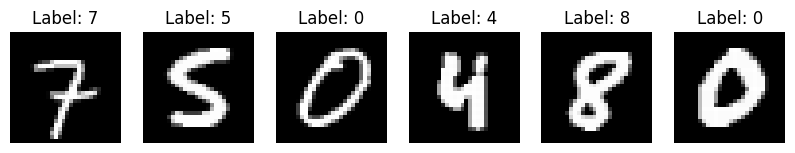

In [8]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()

## Building the Neural Network Model
A **Neural Network (NN)** is a computational model inspired by the structure and functioning of biological neural networks in the human brain. It is designed to recognize patterns, approximate functions, and solve problems in various domains, such as computer vision, natural language processing, and predictive analytics. 

<img src="../images/neuron.jpg" width="900"/>

<img src="../images/neural_network.png" width="700"/>

### Structure of a Neural Network

1. **Input Layer**:
   - Accepts raw data or features as input.
   - Each node in the input layer corresponds to a specific feature or data point.

2. **Hidden Layers**:
   - Composed of one or more layers between the input and output.
   - Each layer consists of **neurons** (or nodes) connected to the neurons in the previous and subsequent layers.
   - Performs computations using weighted inputs, biases, and an **activation function** to introduce non-linearity.

3. **Output Layer**:
   - Produces the final result of the neural network (e.g., a class label in classification tasks or a numerical value in regression tasks).
   - The number of neurons depends on the problem (e.g., 10 neurons for a 10-class classification problem).

### Feedforward Pass
A simple **feedforward neural network** using PyTorch's `torch.nn` module.

In [12]:
# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer (784 -> 128)
        self.fc2 = nn.Linear(128, 64)  # Hidden layer (128 -> 64)
        self.fc3 = nn.Linear(64, 10)  # Output layer (64 -> 10)
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the output layer (logits)
        return x

#### Code Walkthrough

#### 1. Define the Neural Network Class
```python
class NeuralNetwork(nn.Module):
```
- `NeuralNetwork` is a class that inherits from `nn.Module`, which is the base class for all neural networks in PyTorch.
- By inheriting `nn.Module`, the class gains useful methods and functionality to define and train neural networks.

#### 2. Initialize the Network Layers
```python
def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 128) 
    self.fc2 = nn.Linear(128, 64) 
    self.fc3 = nn.Linear(64, 10)
    self.relu = nn.ReLU()
```

- **`__init__` Constructor**:
  - Initializes the network layers and activation functions.
  - `super(NeuralNetwork, self).__init__()` calls the `__init__` method of `nn.Module`, ensuring the base class is properly initialized.

- **`nn.Linear(input_size, output_size)`**:
  - Defines a fully connected (linear) layer:
    - `input_size`: Number of input features.
    - `output_size`: Number of output features.

  Layers defined:
  - `fc1`: First layer takes $28 \times 28 = 784$ input features (flattened MNIST image) and outputs 128 features.
  - `fc2`: Second layer takes 128 features and outputs 64 features.
  - `fc3`: Third layer takes 64 features and outputs 10 features (corresponding to 10 digit classes).

- **Activation Function**:
  - `self.relu = nn.ReLU()`: Defines the Rectified Linear Unit (ReLU) activation function. This introduces non-linearity to the model.


#### 3. Define the Forward Pass
```python
def forward(self, x):
    x = x.view(-1, 28 * 28)  
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x) 
    return x
```

- **Forward Method**:
  - Defines how the input flows through the network (the computation graph).
  - Overridden from `nn.Module`.

- **Step-by-Step Forward Pass**:
  1. **Reshape Input**:
     ```python
     x = x.view(-1, 28 * 28)
     ```
     - Flattens the 2D image tensor of shape `(batch_size, 28, 28)` into a 1D tensor of shape `(batch_size, 784)`.
     - `-1` infers the batch size dynamically.
  
  2. **First Layer**:
     ```python
     x = self.relu(self.fc1(x))
     ```
     - Passes the input through the first fully connected layer (`fc1`) with $784$ inputs and $128$ outputs.
     - Applies the ReLU activation function.

  3. **Second Layer**:
     ```python
     x = self.relu(self.fc2(x))
     ```
     - Passes the output of the first layer through the second fully connected layer (`fc2`) with $128$ inputs and $64$ outputs.
     - Again, applies the ReLU activation function.

  4. **Output Layer**:
     ```python
     x = self.fc3(x)
     ```
     - Passes the output of the second layer through the final layer (`fc3`) with $64$ inputs and $10$ outputs.
     - No activation is applied here, as this is typically done outside the model (e.g., using `Softmax` or `CrossEntropyLoss`).

  5. **Return Output**:
     ```python
     return x
     ```
     - Returns the raw output (logits) from the final layer.

### Key Points

1. **Structure**:
   - This model has three layers:
     - Input: $784 \rightarrow 128$
     - Hidden: $128 \rightarrow 64$
     - Output: $64 \rightarrow 10$

2. **Activation Functions**:
   - ReLU is used for non-linearity in the hidden layers.

3. **Forward Pass**:
   - Defines how the input flows through the network.

4. **Output**:
   - The final output is a set of logits (raw scores) for each of the 10 classes.

#### How It Works with MNIST

- **Input**: MNIST images are $28 \times 28$ grayscale, represented as tensors of shape `(batch_size, 28, 28)`.
- **Output**: The network produces logits for 10 digit classes (0-9).
- **Training**: During training, the output logits are passed to a loss function like `nn.CrossEntropyLoss`, which applies softmax internally and computes the loss.

## Training the Model

### Initializing Model

In [15]:
model = NeuralNetwork()

`model = NeuralNetwork()` creates an instance of the neural network, initializing its layers and activation functions.

This `model` object is now ready for training, evaluation, and inference tasks.

### Initializing Cost Function

In [16]:
criterion = nn.CrossEntropyLoss()

- **`nn.CrossEntropyLoss`** is a PyTorch loss function commonly used for **multi-class classification tasks**.
- It computes the difference between the predicted class probabilities (logits) and the actual class labels.
- The goal is to minimize this loss during training, helping the model improve its predictions.

#### Input to `CrossEntropyLoss`:
- **Predictions (logits)**:
  - The model's output (raw scores) for each class.
  - Shape: $(N, C)$, where $N$ is the batch size, and $C$ is the number of classes.
  - These values are not probabilities but unnormalized scores (logits).
- **Target (labels)**:
  - The ground truth labels (class indices) for the samples in the batch.
  - Shape: $(N,)$, where each value is an integer $0, 1, \ldots, C-1$, representing the class index.

#### Operations Inside `CrossEntropyLoss`:
1. **Logits to Probabilities**:
   - Applies the **Softmax** function to the logits to convert them into probabilities:
     $$
     p_i = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}
     $$
     where $z_i$ is the logit for class $i$, and $C$ is the number of classes.

2. **Negative Log-Likelihood**:
   - Uses the ground truth class labels to compute the **negative log-likelihood**:
     $$
     \text{Loss} = - \frac{1}{N} \sum_{i=1}^N \log(p_{i,y_i})
     $$
     where $y_i$ is the true class for sample $i$, and $p_{i,y_i}$ is the predicted probability for the correct class.

   - This penalizes the model more heavily for assigning low probabilities to the correct class.


#### Why Use `CrossEntropyLoss`?

1. **Combines Softmax and Log-Loss**:
   - Instead of manually applying Softmax and then computing the loss, `nn.CrossEntropyLoss` combines both steps for numerical stability and convenience.

2. **Encourages Correct Class**:
   - Minimizes the loss by assigning higher probabilities to the correct class.

3. **Multi-Class Classification**:
   - Specifically designed for problems where each sample belongs to one of $C$ classes.

#### Key Points

- **Input Shape**:
  - Logits: $(N, C)$
  - Labels: $(N,)$

- **Numerical Stability**:
  - `nn.CrossEntropyLoss` directly works with logits, avoiding precision issues that may arise if you compute Softmax separately.

- **Use Case**:
  - Best suited for **classification tasks** where the output layer has one neuron per class, and the labels are class indices.

### Initializing Optimizer

In [17]:
optimizer = Adam(model.parameters(), lr=0.001)

**Adam** (short for Adaptive Moment Estimation) is an optimization algorithm used to update the model's weights during training. It is a widely used optimizer in deep learning because it combines the strengths of two popular methods: **Momentum** and **RMSProp**.

`Adam` Class:
- `Adam` is a PyTorch implementation of the Adam optimization algorithm.
- It is used to compute and apply gradients during backpropagation.

`model.parameters()`:
- **Purpose**: Specifies the parameters (weights and biases) of the `model` that the optimizer should update.
- `model.parameters()` returns an iterable of all the parameters in the neural network defined by the `NeuralNetwork` class, such as:
  - `fc1.weight`, `fc1.bias`
  - `fc2.weight`, `fc2.bias`
  - `fc3.weight`, `fc3.bias`

`lr=0.001`:
- **Learning Rate (`lr`)**:
  - A hyperparameter that controls the step size at each iteration when updating the weights.
  - Smaller values make the training process slower but more stable, while larger values may speed it up but risk overshooting the optimal solution.

### How Adam Works

The Adam optimizer updates each parameter in the model using this rule:

$$
\theta_t = \theta_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

Where:
- $\theta_t$: Parameter at step $t$.
- $\eta$: Learning rate (`lr`).
- $\hat{m}_t$: Biased-corrected **first moment estimate** (mean of gradients).
- $\hat{v}_t$: Biased-corrected **second moment estimate** (variance of gradients).
- $\epsilon$: Small constant for numerical stability (default: $10^{-8}$).

#### Steps in Adam:
1. Compute the gradient of the loss function with respect to each parameter.
2. Update the first moment estimate $m_t$ (exponentially decaying average of past gradients).
3. Update the second moment estimate $v_t$ (exponentially decaying average of squared gradients).
4. Bias-correct $m_t$ and $v_t$ to avoid initialization issues.
5. Update the parameters using the corrected values.

### Training

In [ ]:
epochs = 5
train_losses = []
val_losses = []

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loss (optional for simplicity)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
    val_losses.append(val_loss / len(test_loader))

    print(
        f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}"
    )

#### **1. Initialization**

```python
for epoch in range(epochs):
```
- **Purpose**: Loops through a predefined number of training epochs.
- **`epochs`**: The number of times the model will iterate over the entire training dataset.

 

#### **2. Training Phase**

```python
model.train()
```
- **Purpose**: Sets the model to training mode.
  - Enables behaviors like dropout (if present) and batch normalization updates.

##### **a. Initialize Training Loss**
```python
train_loss = 0
```
- **Purpose**: Resets the cumulative training loss for the current epoch.

##### **b. Loop Over Batches**
```python
for images, labels in train_loader:
```
- **Purpose**: Iterates through batches of the training data (`images` and corresponding `labels`).
- **`train_loader`**: A `DataLoader` object that handles loading and batching the training data.

##### **c. Zero Out Gradients**
```python
optimizer.zero_grad()
```
- **Purpose**: Clears the gradients of all trainable parameters.
- Without this, gradients from previous steps would accumulate during backpropagation.

##### **d. Forward Pass**
```python
outputs = model(images)
```
- **Purpose**: Passes the input `images` through the model to produce predictions (`outputs`).

##### **e. Compute Loss**
```python
loss = criterion(outputs, labels)
```
- **Purpose**: Calculates the loss between the predicted `outputs` and actual `labels`.
- **`criterion`**: The loss function (e.g., `CrossEntropyLoss`).

##### **f. Backward Pass**
```python
loss.backward()
```
- **Purpose**: Computes the gradients of the loss with respect to the model’s parameters using backpropagation.

##### **g. Update Parameters**
```python
optimizer.step()
```
- **Purpose**: Updates the model’s parameters based on the computed gradients and the optimizer's rules (e.g., Adam, SGD).

##### **h. Accumulate Training Loss**
```python
train_loss += loss.item()
```
- **Purpose**: Adds the scalar value of the current batch loss to the cumulative training loss for the epoch.
- **`loss.item()`**: Converts the tensor loss to a Python float.

##### **i. Store Epoch Training Loss**
```python
train_losses.append(train_loss / len(train_loader))
```
- **Purpose**: Calculates and stores the average training loss for the epoch.

 

#### **3. Validation Phase (Optional)**

```python
model.eval()
```
- **Purpose**: Sets the model to evaluation mode.
  - Disables behaviors like dropout and stops batch normalization updates.

##### **a. No Gradient Computation**
```python
with torch.no_grad():
```
- **Purpose**: Ensures that no gradients are calculated during validation, saving memory and computational overhead.

##### **b. Validation Loss Calculation**
```python
for images, labels in test_loader:
    outputs = model(images)
    val_loss += criterion(outputs, labels).item()
```
- **Purpose**:
  - Loops through the validation data (`test_loader`) to compute the loss for each batch.
  - Adds the scalar batch loss to the cumulative validation loss for the epoch.

##### **c. Store Epoch Validation Loss**
```python
val_losses.append(val_loss / len(test_loader))
```
- **Purpose**: Calculates and stores the average validation loss for the epoch.

 

#### **4. Log Progress**
```python
print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
```
- **Purpose**: Prints the training and validation loss for the current epoch.
- **Formatting**: Displays the loss values rounded to four decimal places.

 

#### **Summary of the Workflow**

1. **Training Phase**:
   - Passes batches of data through the model.
   - Computes the loss, backpropagates, and updates the model’s parameters.
   - Tracks the average training loss for the epoch.

2. **Validation Phase**:
   - Evaluates the model on the validation dataset without updating parameters.
   - Tracks the average validation loss for the epoch.

3. **Logs Losses**:
   - Displays training and validation losses for each epoch.

This structure ensures that the model is both trained and validated in each epoch, with clear logging to monitor performance over time.

## Visualizing Training and Validation Performance

In [ ]:
# Visualization example
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

## Evaluating the Model

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [ ]:
evaluate_model(model, test_loader)

## Saving and Loading the Model

In [ ]:
# Save the model
torch.save(model.state_dict(), "mnist_model.pth")

In [ ]:
# Load the model
loaded_model = NeuralNetwork()
loaded_model.load_state_dict(torch.load("mnist_model.pth"))

## Making Predictions

In [ ]:
# Make predictions
model.eval()
sample_image, sample_label = test_dataset[0]
with torch.no_grad():
    output = model(sample_image.unsqueeze(0))
    _, prediction = torch.max(output, 1)
print(f"True Label: {sample_label}, Predicted Label: {prediction.item()}")

### **Advantages of Neural Networks**
- Can model complex relationships in data.
- Generalize well with sufficient training and regularization.
- Widely applicable to diverse fields such as image recognition, speech processing, and medical diagnostics.

### **Limitations of Neural Networks**
- Requires a large amount of data and computational resources.
- Training can be time-intensive.
- Prone to overfitting if not properly regularized.

In summary, neural networks are powerful tools for solving complex problems, with their success attributed to their ability to learn hierarchical representations of data. When designed and trained effectively, they can achieve remarkable performance across various tasks.